# <b>Data Exploration </b> *✲ﾟ*｡✧٩(･ิᴗ･ิ๑)۶*✲ﾟ*｡✧

## Intro

<b>What data?</b> <br> We are working with the immobilized whole brain imaging data from Kerem and Rebecca. They only include control data, meaning that the worm is a wild type and has no modification apart from the GFP. The data, which were originally stored in separate wbstruct.mat files, have been converted to a dictionary of pandas dataframes (stored in a pickle file for easier handling but also into separate h5 files and csv files for easier sharing). 

<b>What kind of exploration?</b> <br> 
We want to understand the individual datasets and get a feeling of what problems we might face, whether we need to do some processing before we start with the analysis. For now, we especially want to know and make following decisions:
- Are all neurons in each dataset IDed? (If no, remove)
- How many neurons are IDed in each dataset?
- How many times is each neuron IDed in total? (If too few, remove or impute)
- Are neurons with few total number of IDs unique? (If no, impute. Else remove)
- How to deal with missing IDs of nonunique neurons? Which imputation method? 

In [1]:
import helper_functions as hf
import importlib
importlib.reload(hf)
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Quantifications 


We will first look at the number of IDs per neuron in all datasets and the number of IDs per dataset.

In [2]:
# load dataframe dictionaries
dataframes=hf.wbstruct_dataframes.loading_pkl('dataframes_rebecca.pkl')
dataframes_kerem=hf.wbstruct_dataframes.loading_pkl('dataframes_kerem.pkl')

# merging rebecas and kerems dataframe dictionaries
dataframes.update(dataframes_kerem)
hf.wbstruct_dataframes.saving_as_pkl(dataframes, 'dataframes.pkl')
all_IDed_neurons, IDs_per_set = hf.count_IDs(dataframes)

Dataframes stored as a .pkl file. Refer to documentation to load the file.


#### Let's visualize this information with a cute matplotlib plot 

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Plot of datasets and number of IDs'}, xlabel='dataset', ylabel='IDs'>)

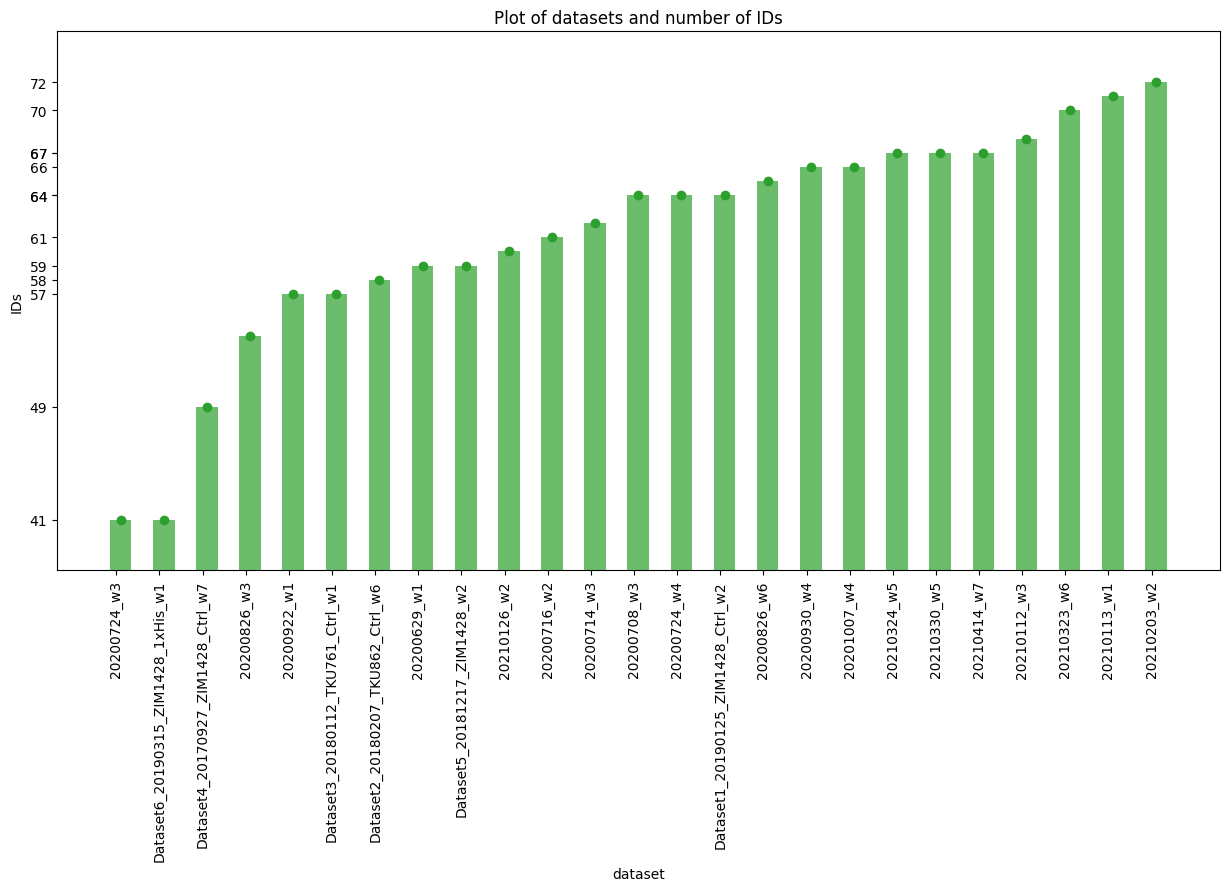

In [3]:
hf.visualize_IDs(IDs_per_set, title="Plot of datasets and number of IDs", xlabel="dataset", ylabel="IDs", coloring="tab:green")

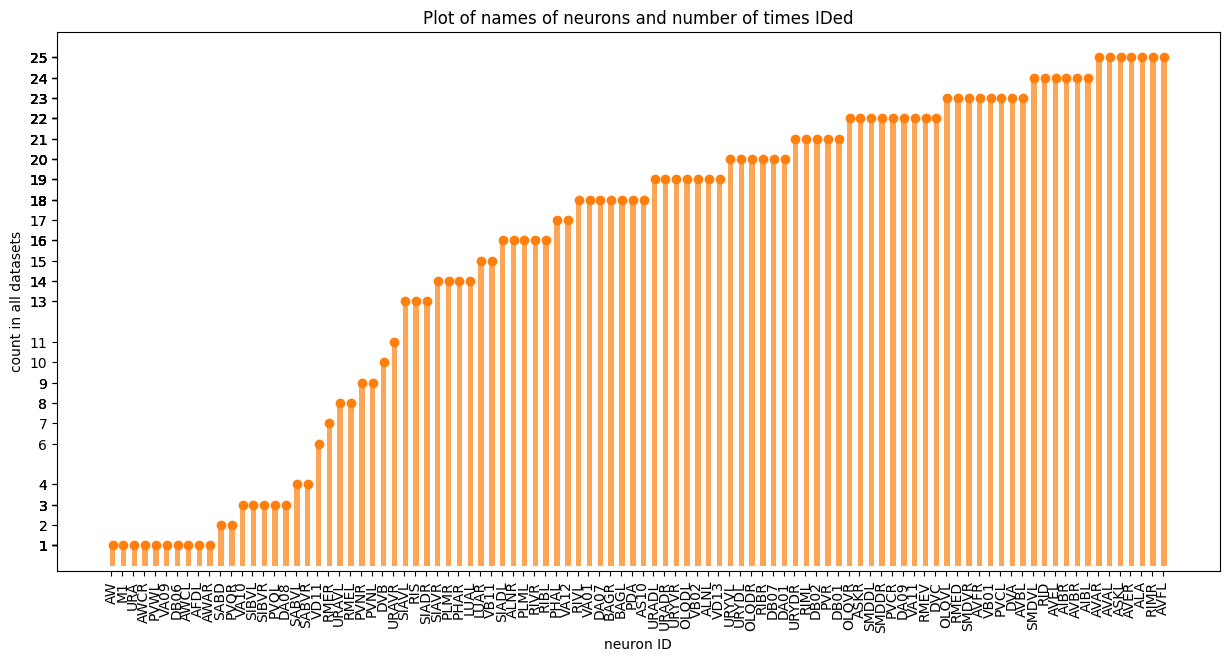

In [4]:
# plot the number of IDed neurons per set
fig, ax = hf.visualize_IDs(all_IDed_neurons, title="Plot of names of neurons and number of times IDed",xlabel="neuron ID",ylabel="count in all datasets",display_all_values=True)
hf.plt.show()


Most neurons are ID'ed more than 16 times while there are some neurons that are IDed less than 10 times. Considering we have 25 datasets, having to impute more IDs that exist in all datasets might not be a good idea. We could set a threshold to only impute IDs that are present in at least 10 datasets. This would reduce the number of IDs to impute to 25.
But before we make the cut we want to know how unique each neuron is. Let's say neuron RMER, which isn't IDed very much, is not very unique in the entirety of the datasets, meaning we could impute the recording of the neuron in all the datasets where it's missing. But if RMER is very unique, the imputation might lead to a completely wrong result.

# 2. "Uniqueness" of neurons

So we want to know two things: how unique is each neuron across all datasets and does it make sense to use PPCA for data imputation considering that it assumes that the variables can be linearly modelled. 
We will run a Least Square Regression model d(=number of datasets)*n(=number of neurons) times where in each round y will be a single neuron and X will be all neurons but y. The aim is to see how well a neuron can be explained by all the other neurons. We can get a rough understanding of this by looking at the R<sup>2</sup> value of each LS model. 

### R-Squared R<sup>2</sup>
The R<sup>2</sup> measures the proportion of the neurons variance or spread explained by all the other neurons. R<sup>2</sup> ranges from 0 to 1 where 1 indicates that all the variance is explained by the other neurons and 0 indicates that none of the variance is explained by the other neurons. Now, if in our case the R<sup>2</sup>-value is high, we can say that the neuron is not very unique and we can impute the missing IDs. If the R<sup>2</sup>-value is low, we can say that the neuron is very unique and we should not impute the missing IDs. We will look at the average R<sup>2</sup> across all datasets. <br>
Runtime: ~ 3 minutes

In [4]:
importlib.reload(hf)
#avg_r2, predictions, raw_data = hf.get_R2_predictions(dataframes, all_IDed_neurons)
avg_r2, predictions, importances, raw_data = hf.get_R2_predictions(dataframes, all_IDed_neurons)

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Average R2 values'}, xlabel='neuron ID', ylabel='R2'>)

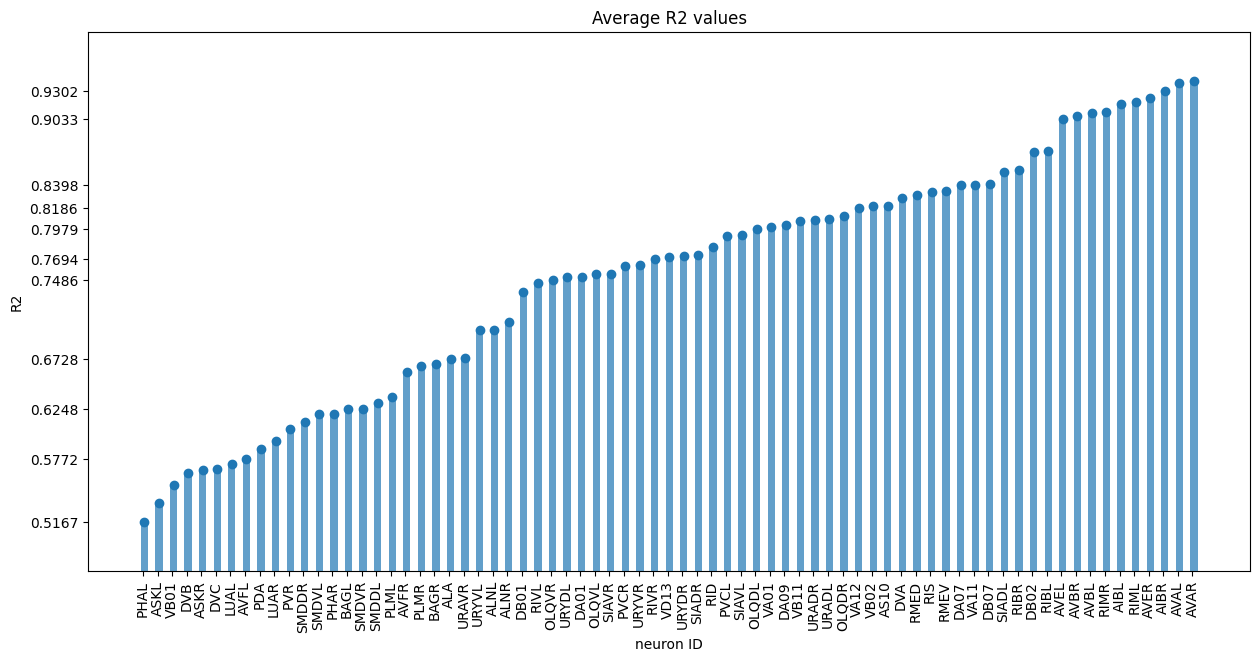

In [5]:
hf.visualize_IDs(avg_r2, title="Average R2 values", xlabel="neuron ID", ylabel="R2", coloring="tab:blue")

In [6]:
min_value = min(avg_r2.values(), key=lambda x: abs(x - 0.7)) # this finds the closest R2 value to 0.7

percent = hf.find_percent(avg_r2.values(), min_value) # this finds the percentage of neurons that have an average R2 value of at least 0.7
print("{:.2f}% of neurons have an average R2 value of at least {:.2f}".format(percent, min_value))

67.81% of neurons have an average R2 value of at least 0.70


Given that more than 67 percent of neurons have an average R<sup>2</sup>-value of at least 0.7, we can say that most neurons are not very unique. This means that we can impute the missing IDs of most neurons and use PPCA for this task.

# 3. ID imputation with PPCA

Probabilistic PCA aims to estimate the principal axes of a datset through maximum likelihood estimation of parameters in a latent variable model. It is a probabilistic formulation of PCA that is more numerically stable and allows for missing data. With PPCA we can impute missing neuronal activities in some of our datasets

In [7]:
stacked_dataframe = hf.pd.concat([df for df in dataframes.values()], ignore_index=True)
threshold = 10

# we stack all neurons that have less than 10 IDs
stacked_dataframe = stacked_dataframe.drop(columns=[neuron for neuron in stacked_dataframe.columns if all_IDed_neurons[neuron] < threshold])

# the data is imputed with PPCA
imputed_dataframe = hf.utils_imputation.impute_missing_values_in_dataframe(stacked_dataframe)
hf.wbstruct_dataframes.saving_as_pkl(imputed_dataframe, "imputed_dataframe.pkl")
imputed_dataframe

c:\Users\ZimAdmin\AppData\Local\Programs\Python\Python310\lib\site-packages\ppca\_ppca.py:82: RuntimeWarning: divide by zero encountered in log
  det = np.log(np.linalg.det(Sx))


Dataframes stored as a .pkl file. Refer to documentation to load the file.


,URADL,URADR,URYVR,URYVL,URYDR,URYDL,OLQDL,OLQVL,URAVR,RMED,...,DB01,DA01,DVB,DVC,PDA,AS10,VB11,RIVR,RIBL,SIADR
0,0.362247,0.268870,0.207330,0.304520,0.261854,0.264241,0.718043,0.424508,0.180676,0.262258,...,0.368521,0.796359,0.404108,0.967522,0.165893,0.413762,0.298622,0.370100,0.355959,0.314257
1,0.334562,0.285975,0.232692,0.272279,0.240964,0.285008,0.698511,0.396316,0.195020,0.220053,...,0.349103,0.786970,0.376870,0.931212,0.143421,0.383145,0.273280,0.355008,0.345658,0.316868
2,0.337621,0.274959,0.256516,0.311110,0.266116,0.299377,0.712704,0.426034,0.208328,0.226081,...,0.352517,0.766402,0.407139,0.948450,0.152761,0.403492,0.275834,0.371157,0.382470,0.302208
3,0.297204,0.242873,0.176090,0.256018,0.224283,0.239688,0.644670,0.389113,0.171029,0.194837,...,0.294627,0.719664,0.350029,0.878711,0.154988,0.376709,0.229049,0.318835,0.300281,0.271002
4,0.324939,0.239417,0.182565,0.268602,0.223360,0.254398,0.639860,0.389503,0.152927,0.193422,...,0.306806,0.709229,0.336295,0.863131,0.148822,0.370140,0.223945,0.321356,0.286991,0.259077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88539,0.071645,0.070808,0.109236,0.090198,0.070679,0.103842,0.145707,0.039689,0.063898,0.809000,...,0.245616,0.406375,0.238901,0.711694,0.225886,0.325087,0.163483,0.080279,0.035517,0.012778
88540,0.051107,0.064703,0.103091,0.083117,0.026907,0.063788,0.131263,0.040000,0.066297,0.788587,...,0.242059,0.424368,0.241309,0.684090,0.219790,0.313545,0.168102,0.064952,0.048814,0.030170
88541,0.074116,0.075931,0.105557,0.091175,0.073201,0.091530,0.141605,0.053817,0.065694,0.790447,...,0.233480,0.413030,0.234259,0.697885,0.228468,0.315008,0.149123,0.057847,0.038570,0.016279
88542,0.072022,0.071452,0.110257,0.093467,0.066290,0.097600,0.145602,0.063853,0.065627,0.773798,...,0.223214,0.411529,0.227757,0.687582,0.221217,0.320361,0.158508,0.070672,0.051676,0.007106


# Appendix I: Variable p-values of the linear regression model

We want to know which neurons were important for modelling some of the neurons in the datasets. We will look at the p-values of each linear regression model. The p-value indicates the significance of each variable during the modelling of each neuron.

Calculation of p-value: 

In [8]:
# we take the mean VIP score of each neuron, sort them and take the top 5
for key,value in importances.items():
    for neuron, list in value.items():
        importances[key][neuron] = hf.np.mean(list)
    importances[key] = sorted(importances[key].items(), key=lambda item: item[1], reverse=True)[:5]

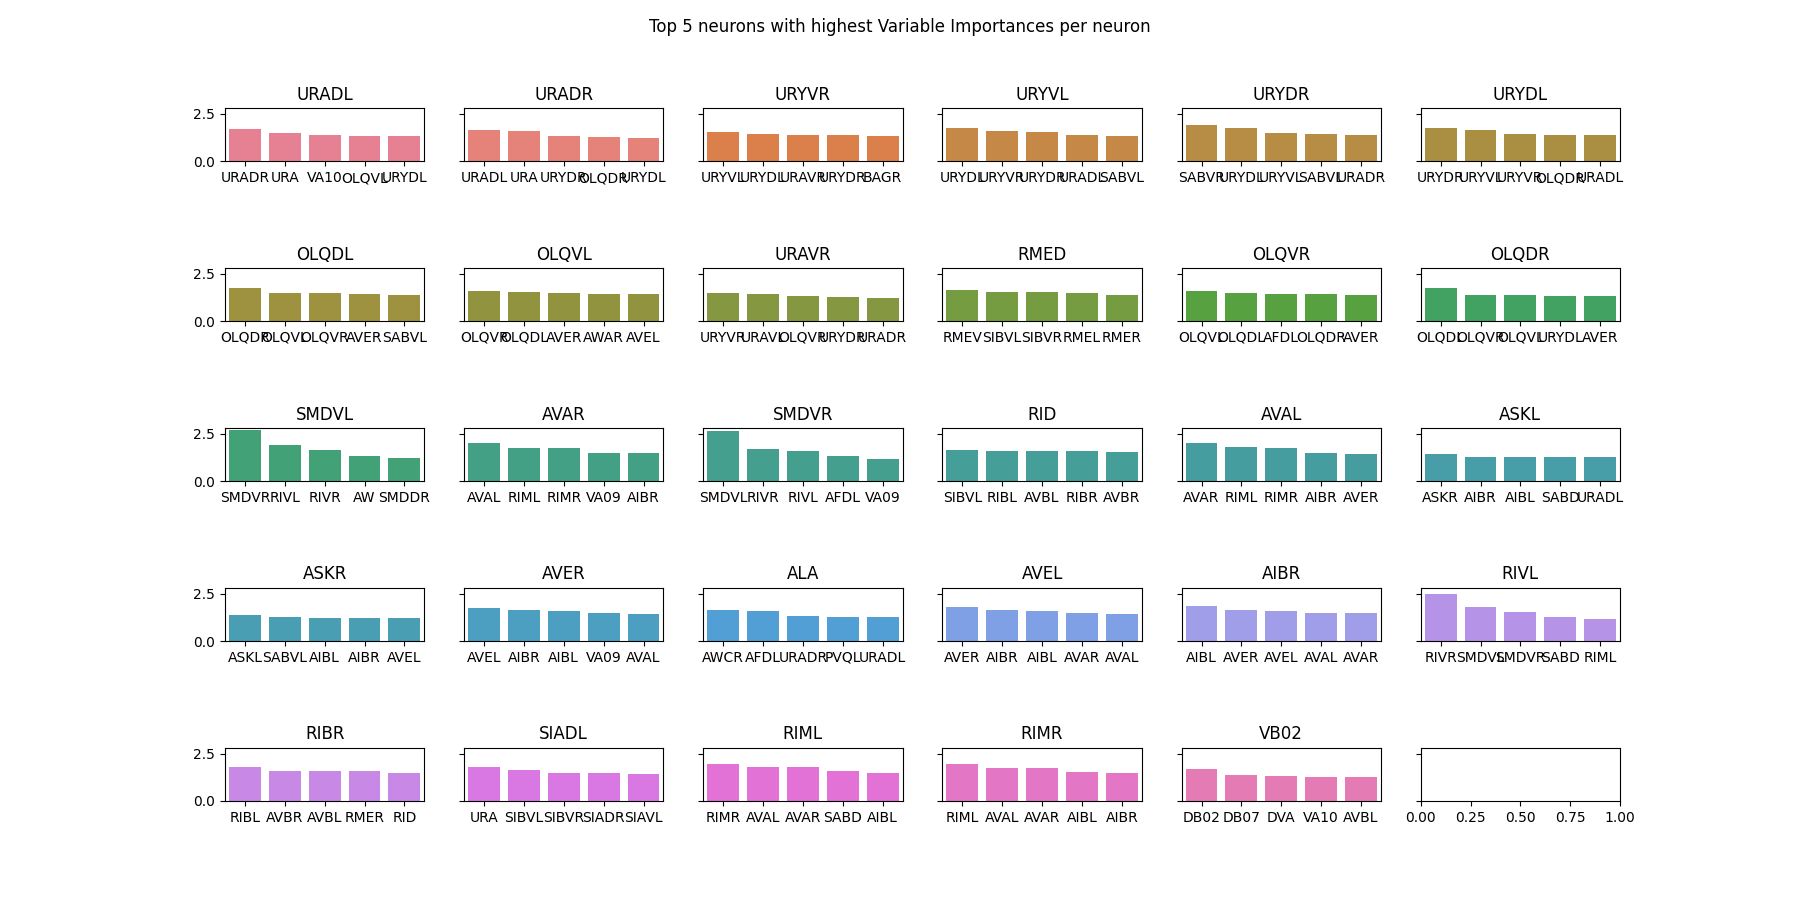

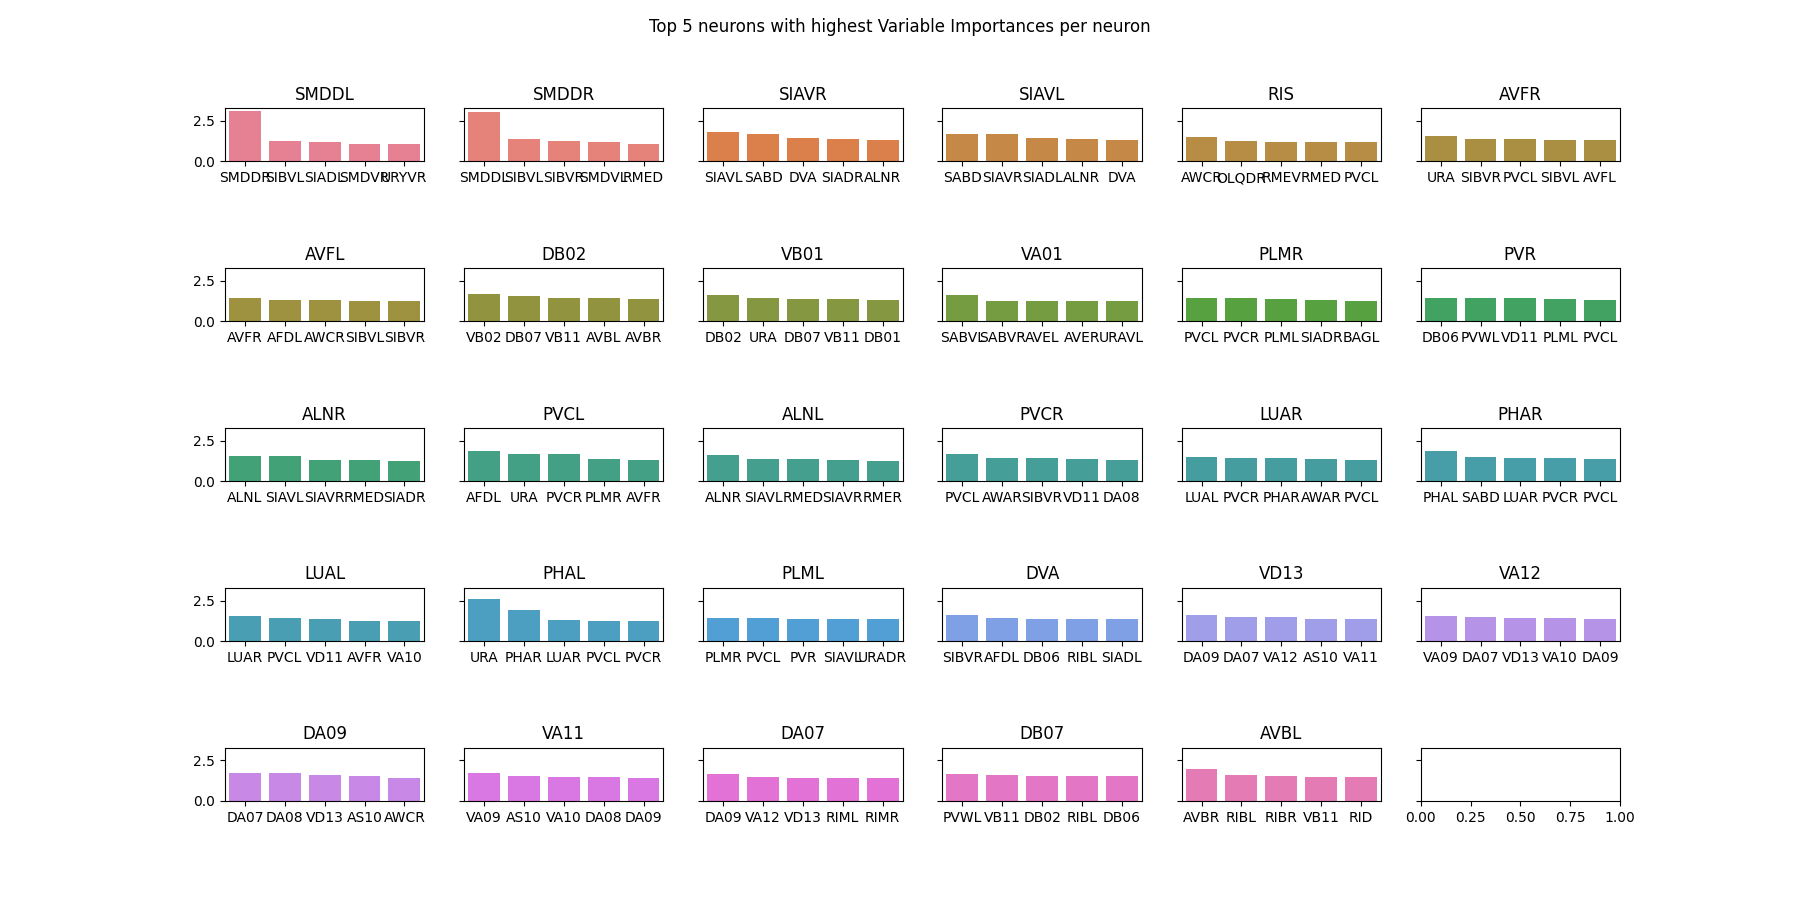

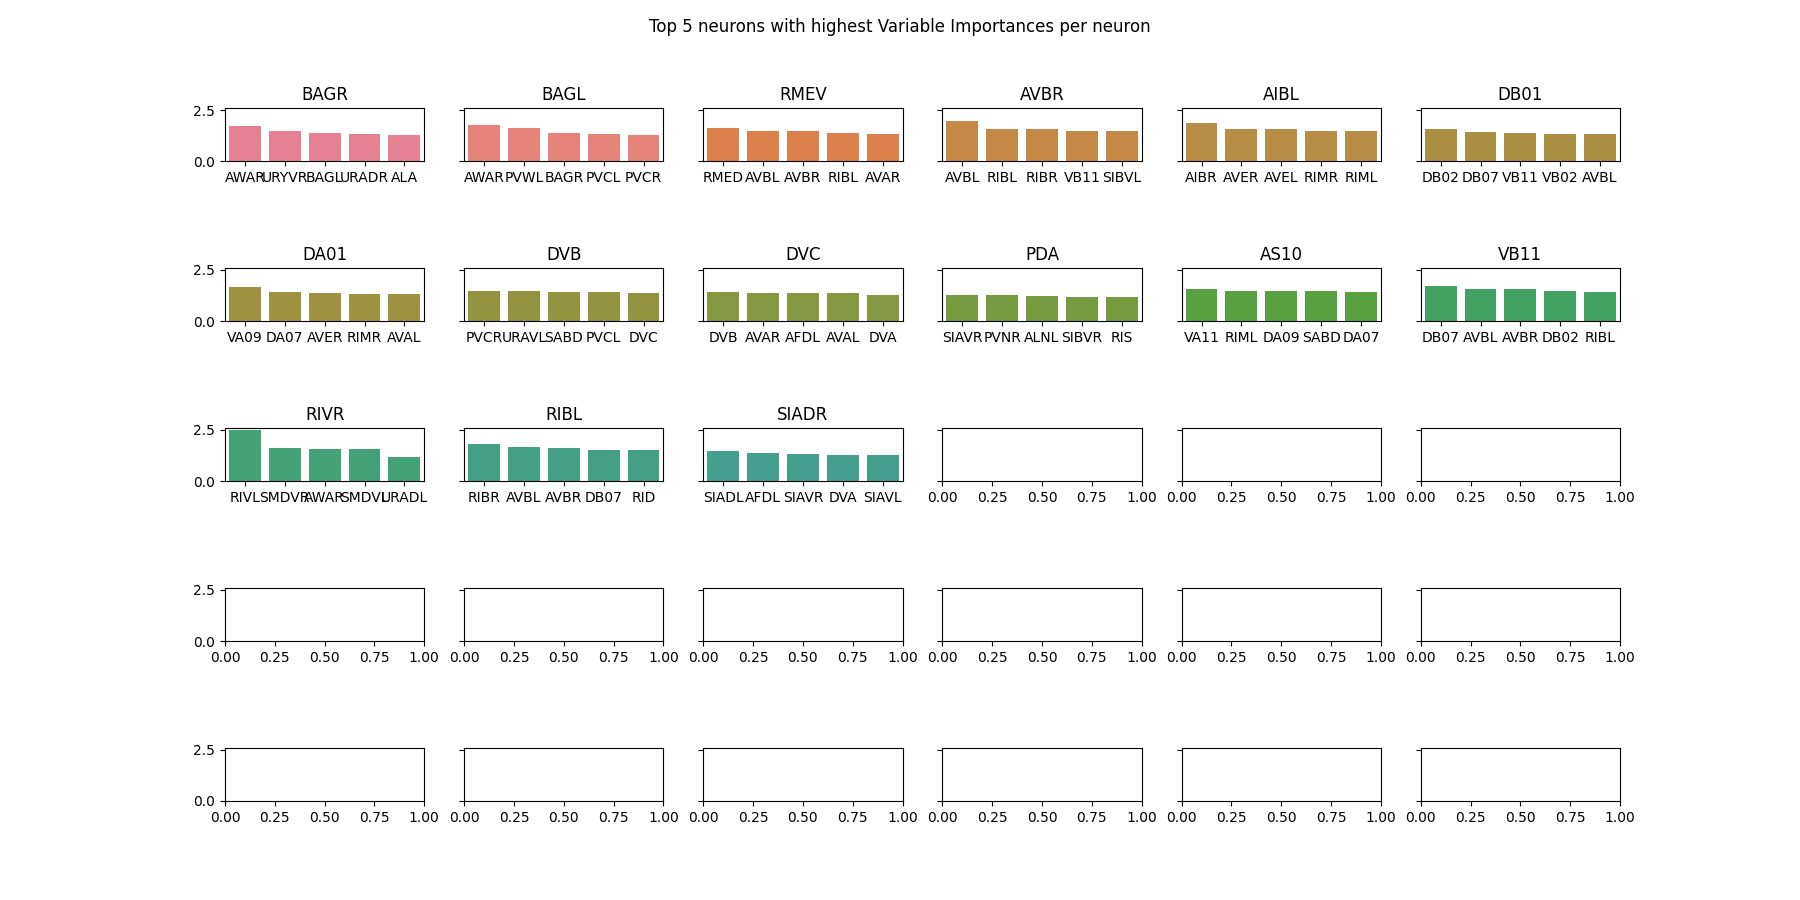

In [50]:
# we plot the top 5 neurons with the highest variable importances per neuron
fig, axes = plt.subplots(5, 6, figsize=(18, 9), sharey=True)
fig.suptitle('Top 5 neurons with highest Variable Importances per neuron')
plt.subplots_adjust(hspace = 2)
axes = axes.flatten()
count = 0
palette = iter(sns.husl_palette(30))
for i in importances.keys():
    
    keys = [neuron[0] for neuron in importances[i]]
    vals = [neuron[1] for neuron in importances[i]]
    sns.barplot(ax = axes[count], x=keys, y=vals, dodge=False, color=next(palette))
    axes[count].set_title(i)
    count = count + 1
    
    # cut off the plot after 30 neurons so that the plot is not too big
    if count % round(len(importances.keys())/2.5) == 0:
        plt.show()
        fig, axes = plt.subplots(5, 6, figsize=(18, 9), sharey=True)
        fig.suptitle('Top 5 neurons with highest Variable Importances per neuron')
        plt.subplots_adjust(hspace = 2)
        axes = axes.flatten()
        count = 0
        palette = iter(sns.husl_palette(30))
    


# Appendix II: Saving plots

### Modelled neuron activity against true activity

In [13]:
%%capture
%matplotlib widget
# we don't want to output all plots, just save them

delta_path="C:\\Users\\LAK\\Documents\\plots\\delta_plots\\"
model_path="C:\\Users\\LAK\\Documents\\plots\\modelled_plots\\"

plot_kwargs = {'alpha': 0.7}

hf.plot_from_single_imputed(raw_data, predictions, delta_path, model_path, plot_kwargs=plot_kwargs)

### Imputed neuron activity against existing true activity

In [17]:
%%capture 

from collections import defaultdict

# we will save all dataframe keys and their lengths in a dictionary for the unstacking part
length_dict = defaultdict()
for key, value in dataframes.items():
    length_dict[key] = len(value)

saving_path="C:\\Users\\LAK\\Documents\\plots\\imputed_plots\\"

hf.plot_from_stacked_imputed(length_dict, imputed_dataframe, stacked_dataframe, saving_path)